In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('/content/drive/MyDrive/BMKG/1. Kualitas Udara & AWS/dataset/final_dataset.csv')

In [5]:
df.head()

,Tanggal,pm25,rr,ws_avg,ws_max,wd_avg,wd_sin,wd_cos,tt_air_max,tt_air_avg,tt_air_min,rh_avg,sr_avg,pp_air,hour_sin,hour_cos,month_sin,month_cos
0,2024-01-01 07:00:00,35.2,20.4,0.796000,2.627331,250.771311,-0.568235,-0.198199,28.08,26.676667,25.25,89.321305,327.266667,990.462217,0.965926,-0.258819,0.5,0.866025
1,2024-01-01 08:00:00,9.1,0.0,0.654500,2.234687,213.220428,-0.322189,-0.491973,29.22,28.550000,27.80,80.528333,491.183333,991.110700,0.866025,-0.500000,0.5,0.866025
2,2024-01-01 09:00:00,18.5,0.0,0.835833,3.352323,218.088163,-0.605159,-0.772117,30.50,29.661667,28.91,75.260000,674.400000,991.152733,0.707107,-0.707107,0.5,0.866025
3,2024-01-01 10:00:00,17.5,0.0,1.110833,3.481706,223.482799,-0.619864,-0.653593,31.48,30.720000,30.18,70.248333,759.833333,990.364683,0.500000,-0.866025,0.5,0.866025
4,2024-01-01 11:00:00,23.0,0.0,1.436833,4.099219,226.547640,-0.641812,-0.608043,32.49,31.780000,31.19,64.065000,865.383333,989.523517,0.258819,-0.965926,0.5,0.866025


In [6]:
target_col = 'pm25'

# Fitur yang TIDAK BOLEH masuk training:
# - pm25 (Jelas, ini jawabannya)
# - wd_avg (Karena sudah ada wd_sin & wd_cos)
cols_excluded = [target_col, 'wd_avg', 'tt_air_max', 'tt_air_min', 'Tanggal']

# Buat X dengan membuang kolom-kolom terlarang itu
X = df.drop(columns=cols_excluded, errors='ignore')
y = df[target_col]

print("Setup Selesai!")
print(f"-> Fitur yang masuk model ({X.shape[1]} kolom):")
print(f"{list(X.columns)}")
print("\n-> Pastikan TIDAK ADA 'wd_avg', 'hour', 'month', atau 'pm25' di list atas.")

Setup Selesai!
-> Fitur yang masuk model (13 kolom):
['rr', 'ws_avg', 'ws_max', 'wd_sin', 'wd_cos', 'tt_air_avg', 'rh_avg', 'sr_avg', 'pp_air', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']

-> Pastikan TIDAK ADA 'wd_avg', 'hour', 'month', atau 'pm25' di list atas.


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [8]:
# df.set_index('Tanggal', inplace=True)

In [9]:
from sklearn.ensemble import RandomForestRegressor

# rf = RandomForestRegressor(
#     n_estimators=500,        # Ditambah agar lebih stabil (low variance)
#     max_depth=None,          # Biarkan model belajar pola kompleks
#     min_samples_leaf=2,      # Lebih sensitif terhadap perubahan PM2.5
#     min_samples_split=5,     # Tambahan: kontrol agar tidak terlalu overfit
#     max_features='sqrt',     # Membantu generalisasi model
#     random_state=42,
#     n_jobs=-1
# )

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=10,
    # max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=10, n_estimators=500,
                      n_jobs=-1, random_state=42)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [11]:
import numpy as np

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

MAE  : 10.04
RMSE : 13.08


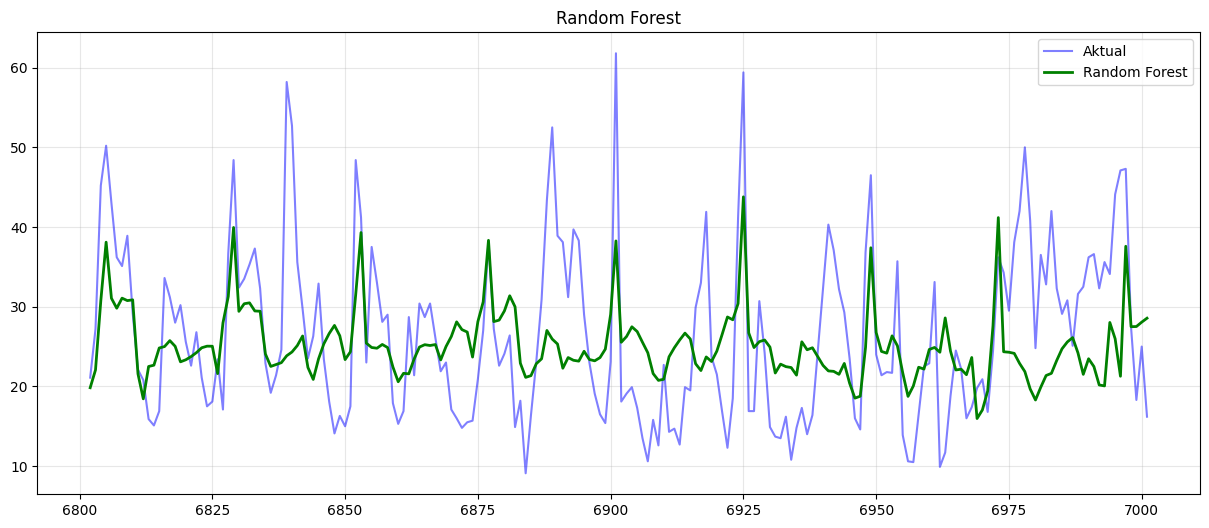

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
limit = 200
plt.plot(y_test.index[:limit], y_test.iloc[:limit], label='Aktual', color='blue', alpha=0.5)
plt.plot(y_test.index[:limit], y_pred[:limit], label='Random Forest', color='green', linewidth=2)
plt.title('Random Forest')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Target log-transform

In [13]:
y_train_log = np.log1p(y_train)
rf.fit(X_train, y_train_log)

y_pred = np.expm1(rf.predict(X_test))

In [14]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

MAE  : 9.77
RMSE : 13.17


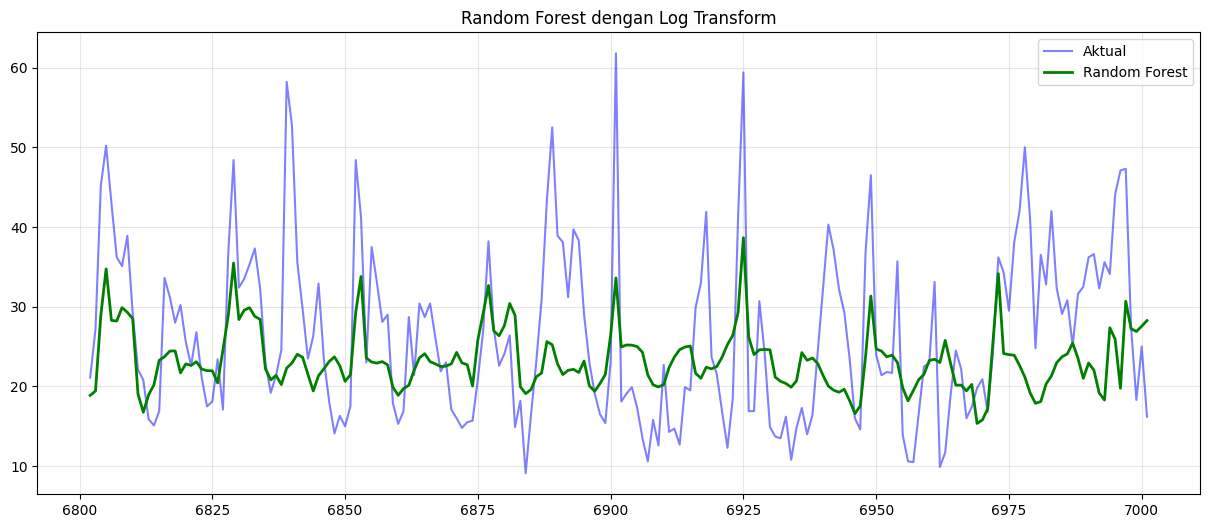

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
limit = 200
plt.plot(y_test.index[:limit], y_test.iloc[:limit], label='Aktual', color='blue', alpha=0.5)
plt.plot(y_test.index[:limit], y_pred[:limit], label='Random Forest', color='green', linewidth=2)
plt.title('Random Forest dengan Log Transform')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Support Vector Regressor

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [17]:
y_train_log_svr = np.log1p(y_train)

In [18]:
from sklearn.svm import SVR

svr_rbf = SVR(
    kernel='rbf',
    C=50,
    gamma='scale',
    epsilon=0.1
)

In [19]:
svr_rbf.fit(X_train_scaled, y_train_log_svr)

SVR(C=50)

In [20]:
y_pred_svr = np.expm1(svr_rbf.predict(X_test_scaled))

In [42]:
mae = mean_absolute_error(y_test, y_pred_svr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_svr))

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

MAE  : 13.01
RMSE : 17.63


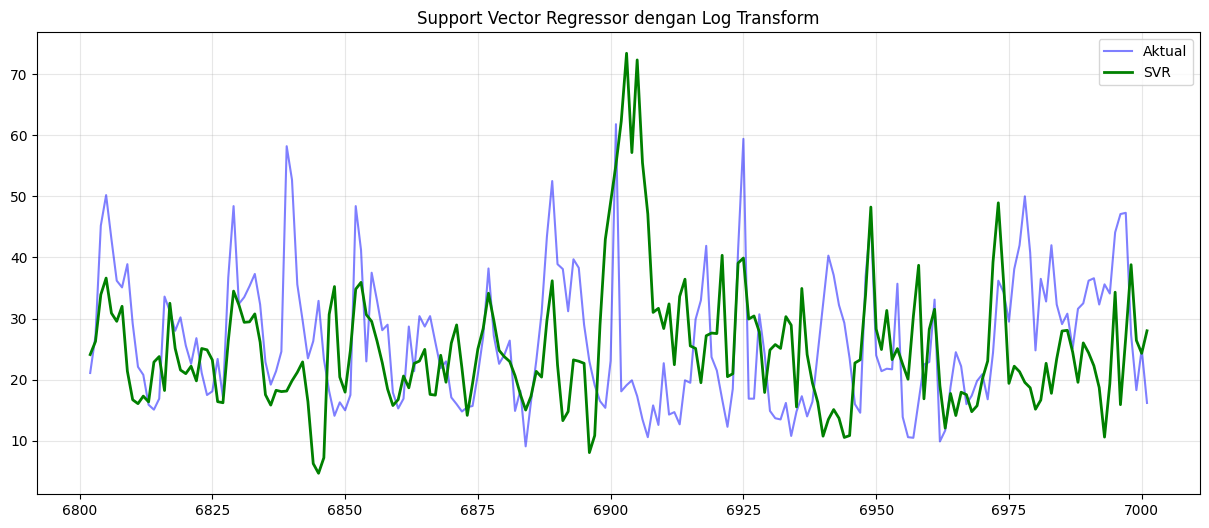

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
limit = 200
plt.plot(y_test.index[:limit], y_test.iloc[:limit], label='Aktual', color='blue', alpha=0.5)
plt.plot(y_test.index[:limit], y_pred_svr[:limit], label='SVR', color='green', linewidth=2)
plt.title('Support Vector Regressor dengan Log Transform')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## XGBoost

In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    early_stopping_rounds=30,
    random_state=42
)


In [24]:
y_train_log_xgb = np.log1p(y_train)
y_test_log_xgb  = np.log1p(y_test)

In [25]:
xgb.fit(
    X_train, y_train_log_xgb,
    eval_set=[(X_test, y_test_log_xgb)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [26]:
y_pred_xgb = np.expm1(xgb.predict(X_test))
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")

MAE  : 10.19
RMSE : 14.09


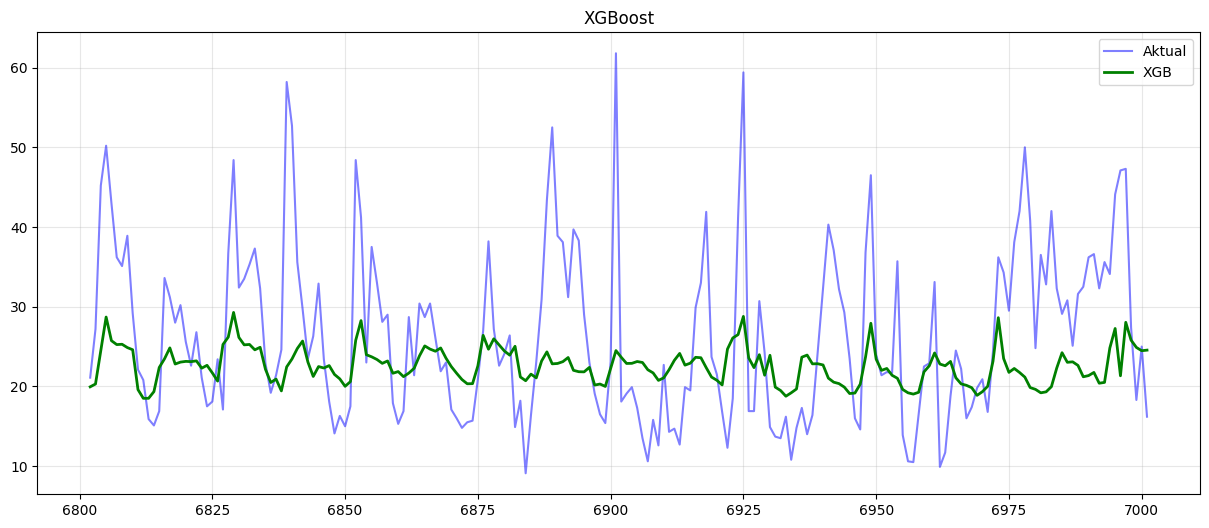

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
limit = 200
plt.plot(y_test.index[:limit], y_test.iloc[:limit], label='Aktual', color='blue', alpha=0.5)
plt.plot(y_test.index[:limit], y_pred_xgb[:limit], label='XGB', color='green', linewidth=2)
plt.title('XGBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Random Forest Sudah Mentok

In [28]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE RF  : {mae:.2f}")
print(f"RMSE RF : {rmse:.2f}")

MAE RF  : 9.77
RMSE RF : 13.17


In [29]:
import joblib

# daftar fitur FINAL (INI PENTING)
FEATURES = list(X.columns)

# simpan model + metadata
joblib.dump(
    {
        'model': rf,
        'features': FEATURES
    },
    'rf_pm25_estimator.joblib'
)

print("Model berhasil disimpan!")


Model berhasil disimpan!


In [30]:
print(list(X.columns))

['rr', 'ws_avg', 'ws_max', 'wd_sin', 'wd_cos', 'tt_air_avg', 'rh_avg', 'sr_avg', 'pp_air', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']


In [31]:
import joblib
import numpy as np
import pandas as pd

bundle = joblib.load('rf_pm25_estimator.joblib')
model = bundle['model']
FEATURES = bundle['features']

In [48]:
input_data = {
    'rr': 0,
    'ws_avg': 0.917,
    'ws_max': 2.442755,
    'wd_sin': 0.5,
    'wd_cos': -0.8,
    'tt_air_avg': 30.15,
    'rh_avg': 73.86,
    'sr_avg': 835,
    'pp_air': 990.7862,
    # "rr": 0,
    # "ws_avg": 3.5,
    # "ws_max": 7.2,
    # "wd_sin":0.7071,
    # "wd_cos":0.7071,
    # "tt_air_avg": 24,
    # "rh_avg": 45,
    # "sr_avg": 500,
    # "pp_air": 1013,
    'hour_sin': 0.87,
    'hour_cos': -0.5,
    'month_sin': 0.5,
    'month_cos': 0.87
}


In [50]:
X_input = pd.DataFrame([input_data])

# pastikan urutan fitur sama persis
X_input = X_input[FEATURES]


In [51]:
y_pred_log = model.predict(X_input)
pm25_pred = np.expm1(y_pred_log)[0]

print(f"Estimasi PM2.5: {pm25_pred:.1f} µg/m³")

Estimasi PM2.5: 28.1 µg/m³


In [37]:
def kategori_pm25(pm):
    if pm <= 15:
        return "Baik"
    elif pm <= 35:
        return "Sedang"
    elif pm <= 55:
        return "Tidak Sehat"
    else:
        return "Sangat Tidak Sehat"

kategori = kategori_pm25(pm25_pred)
print("Kategori:", kategori)

Kategori: Baik


In [38]:
print("Catatan: Nilai ini merupakan estimasi berbasis kondisi meteorologi.")

Catatan: Nilai ini merupakan estimasi berbasis kondisi meteorologi.
